# Rebuild Margin Query Strategy in ALiPY

In [45]:
def _get_proba_pred(unlabel_x, model):
    """Get the probabilistic prediction results of the unlabeled set.
    Parameters
    ----------
    unlabel_x: 2d array
        Feature matrix of the unlabeled set.
    model: object
        Model object which has the method predict_proba.
    Returns
    -------
    pv: np.ndarray
        Probability predictions matrix with shape [n_samples, n_classes].
    spv: tuple
        Shape of pv.
    """
    if not hasattr(model, 'predict_proba'):
        raise Exception('model object must implement predict_proba methods in current algorithm.')
    pv = model.predict_proba(unlabel_x)
    pv = np.asarray(pv)
    spv = np.shape(pv)
    if len(spv) != 2 or spv[1] == 1:
        raise Exception('2d array with [n_samples, n_class] is expected, but received: \n%s' % str(pv))
    return pv, spv

In [57]:
def _is_arraylike(x):
    """Returns whether the input is array-like"""
    return (hasattr(x, '__len__') or
            hasattr(x, 'shape') or
            hasattr(x, '__array__'))


def nlargestarg(a, n):
    """Return n largest values' indexes of the given array a.
    Parameters
    ----------
    a: {list, np.ndarray}
        Data array.
    n: int
        The number of returned args.
    Returns
    -------
    nlargestarg: list
        The n largest args in array a.
    """
    assert (_is_arraylike(a))
    assert (n > 0)
    argret = np.argsort(a)
    # ascent
    return argret[argret.size - n:]


def nsmallestarg(a, n):
    """Return n smallest values' indexes of the given array a.
    Parameters
    ----------
    a: {list, np.ndarray}
        Data array.
    n: int
        The number of returned args.
    Returns
    -------
    nlargestarg: list
        The n smallest args in array a.
    """
    assert (_is_arraylike(a))
    assert (n > 0)
    argret = np.argsort(a)
    # ascent
    return argret[0:n]

In [58]:
def randperm(n, k=None):
    """Generate a random array which contains k elements range from (n[0]:n[1])
    Parameters
    ----------
    n: int or tuple
        range from [n[0]:n[1]], include n[0] and n[1].
        if an int is given, then n[0] = 0
    k: int, optional (default=end - start + 1)
        how many numbers will be generated. should not larger than n[1]-n[0]+1,
        default=n[1] - n[0] + 1.
    Returns
    -------
    perm: list
        the generated array.
    """
    if isinstance(n, np.generic):
        # n = np.asscalar(n)  # deprecated in numpy v1.16
        n = n.item()
    if isinstance(n, tuple):
        if n[0] is not None:
            start = n[0]
        else:
            start = 0
        end = n[1]
    elif isinstance(n, int):
        start = 0
        end = n
    else:
        raise TypeError("n must be tuple or int.")

    if k is None:
        k = end - start + 1
    if not isinstance(k, int):
        raise TypeError("k must be an int.")
    if k > end - start + 1:
        raise ValueError("k should not larger than n[1]-n[0]+1")

    randarr = np.arange(start, end + 1)
    np.random.shuffle(randarr)
    return randarr[0:k]

In [65]:
class customQueryInstanceUncertainty:
    """Uncertainty query strategy.
    The implement of uncertainty measure includes:
    1. margin sampling
    2. least confident
    3. entropy
    The above measures need the probabilistic output of the model.
    There are 3 ways to select instances in the data set.
    1. use select if you are using sklearn model.
    2. use the default logistic regression model to choose the instances
       by passing None to the model parameter.
    3. use select_by_prediction_mat by providing the probabilistic prediction
       matrix of your own model, shape [n_samples, n_classes].
    Parameters
    ----------
    X: 2D array, optional (default=None)
        Feature matrix of the whole dataset. It is a reference which will not use additional memory.
    y: array-like, optional (default=None)
        Label matrix of the whole dataset. It is a reference which will not use additional memory.
    measure: str, optional (default='entropy')
        measurement to calculate uncertainty, should be one of
        ['least_confident', 'margin', 'entropy', 'distance_to_boundary']
        --'least_confident' x* = argmax 1-P(y_hat|x) ,where y_hat = argmax P(yi|x)
        --'margin' x* = argmax P(y_hat1|x) - P(y_hat2|x), where y_hat1 and y_hat2 are the first and second
            most probable class labels under the model, respectively.
        --'entropy' x* = argmax -sum(P(yi|x)logP(yi|x))
        --'distance_to_boundary' Only available in binary classification, x* = argmin |f(x)|,
            your model should have 'decision_function' method which will return a 1d array.
    """

    def __init__(self, X=None, y=None, measure='margin'):
#         if measure not in ['least_confident', 'margin', 'entropy', 'distance_to_boundary']:
#             raise ValueError("measure must be one of ['least_confident', 'margin', 'entropy', 'distance_to_boundary']")
        self.measure = measure
        self.X = X
        self.y = y
#         super(QueryInstanceUncertainty, self).__init__(X, y)

    def select(self, label_index, unlabel_index, model=None, batch_size=1):
        """Select indexes from the unlabel_index for querying.
        Parameters
        ----------
        label_index: {list, np.ndarray, IndexCollection}
            The indexes of labeled samples.
        unlabel_index: {list, np.ndarray, IndexCollection}
            The indexes of unlabeled samples.
        model: object, optional (default=None)
            Current classification model, should have the 'predict_proba' method for probabilistic output.
            If not provided, LogisticRegression with default parameters implemented by sklearn will be used.
        batch_size: int, optional (default=1)
            Selection batch size.
        Returns
        -------
        selected_idx: list
            The selected indexes which is a subset of unlabel_index.
        """
        assert (batch_size > 0)
        assert (isinstance(unlabel_index, collections.Iterable))
        unlabel_index = np.asarray(unlabel_index)
        if len(unlabel_index) <= batch_size:
            return unlabel_index

        # get unlabel_x
        if self.X is None:
            raise Exception('Data matrix is not provided, use select_by_prediction_mat() instead.')
        if model is None:
            model = LogisticRegression(solver='liblinear')
            model.fit(self.X[label_index if isinstance(label_index, (list, np.ndarray)) else label_index.index],
                      self.y[label_index if isinstance(label_index, (list, np.ndarray)) else label_index.index])
        unlabel_x = self.X[unlabel_index, :]
        ##################################
        if self.measure == 'distance_to_boundary':
            if not hasattr(model, 'decision_function'):
                raise TypeError(
                    'model object must implement decision_function methods in distance_to_boundary measure.')
            pv = np.absolute(model.decision_function(unlabel_x))
            spv = np.shape(pv)
            assert (len(spv) in [1, 2])
            if len(spv) == 2:
                if spv[1] != 1:
                    raise Exception('1d or 2d with 1 column array is expected, but received: \n%s' % str(pv))
                else:
                    pv = np.absolute(np.array(pv).flatten())
            return unlabel_index[nsmallestarg(pv, batch_size)]

        pv, _ = _get_proba_pred(unlabel_x, model)
        return self.select_by_prediction_mat(unlabel_index=unlabel_index, predict=pv,
                                             batch_size=batch_size)

    def select_by_prediction_mat(self, unlabel_index, predict, batch_size=1):
        """Select indexes from the unlabel_index for querying.
        Parameters
        ----------
        unlabel_index: {list, np.ndarray, IndexCollection}
            The indexes of unlabeled samples. Should be one-to-one
            correspondence to the prediction matrix.
        predict: 2d array, shape [n_samples, n_classes]
            The probabilistic prediction matrix for the unlabeled set.
        batch_size: int, optional (default=1)
            Selection batch size.
        Returns
        -------
        selected_idx: list
            The selected indexes which is a subset of unlabel_index.
        """
        assert (batch_size > 0)
        assert (isinstance(unlabel_index, collections.Iterable))
        unlabel_index = np.asarray(unlabel_index)
        if len(unlabel_index) <= batch_size:
            return unlabel_index

        pv = np.asarray(predict)  # predict value
        spv = np.shape(pv)  # shape of predict value


        if self.measure == 'margin':
            # calc margin
            pat = np.partition(pv, (spv[1] - 2, spv[1] - 1), axis=1)
            pat = pat[:, spv[1] - 2] - pat[:, spv[1] - 1]
            return unlabel_index[nlargestarg(pat, batch_size)]

        if self.measure == 'least_confident':
            # calc least_confident
            pat = np.partition(pv, spv[1] - 1, axis=1)
            pat = 1 - pat[:, spv[1] - 1]
            return unlabel_index[nlargestarg(pat, batch_size)]

   


| round | initially labeled data | number of queries | cost | Performance: |
|   0   |    10 (9.52% of all)   |         50        |  0   | 0.950 ± 0.07 |
| round | initially labeled data | number of queries | cost | Performance: |
|   1   |    10 (9.52% of all)   |         50        |  0   | 0.969 ± 0.08 |
| round | initially labeled data | number of queries | cost | Performance: |
|   2   |    10 (9.52% of all)   |         50        |  0   | 0.926 ± 0.03 |
| round | initially labeled data | number of queries | cost | Performance: |
|   3   |    10 (9.52% of all)   |         50        |  0   | 0.942 ± 0.03 |
| round | initially labeled data | number of queries | cost | Performance: |
|   4   |    10 (9.52% of all)   |         50        |  0   | 0.974 ± 0.06 |
| round | initially labeled data | number of queries | cost | Performance: |
|   5   |    10 (9.52% of all)   |         50        |  0   | 0.965 ± 0.04 |
| round | initially labeled data | number of queries | cost | Performance: 

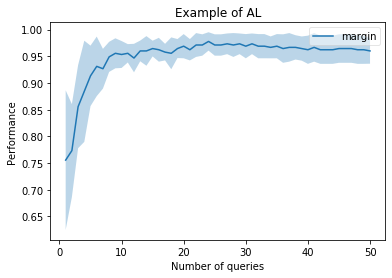

In [82]:
import copy
from sklearn.datasets import load_iris
from alipy import ToolBox

X, y = load_iris(return_X_y=True)
alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path='.')

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=10)

# Use the default Logistic Regression classifier
model = alibox.get_default_model()

# The cost budget is 50 times querying
stopping_criterion = alibox.get_stopping_criterion('num_of_queries', 50)

# Use pre-defined strategy
QBCStrategy = customQueryInstanceUncertainty(X,y)
QBC_result = []

for round in range(10):
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
    # Get intermediate results saver for one fold experiment
    saver = alibox.get_stateio(round)

    while not stopping_criterion.is_stop():
        # Select a subset of Uind according to the query strategy
        # Passing model=None to use the default model for evaluating the committees' disagreement
        select_ind = QBCStrategy.select(label_ind, unlab_ind, model=None, batch_size=1)
        label_ind.update(select_ind)
        unlab_ind.difference_update(select_ind)

        # Update model and calc performance according to the model you are using
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')

        # Save intermediate results to file
        st = alibox.State(select_index=select_ind, performance=accuracy)
        saver.add_state(st)
        saver.save()

        # Passing the current progress to stopping criterion object
        stopping_criterion.update_information(saver)
    # Reset the progress in stopping criterion object
    stopping_criterion.reset()
    QBC_result.append(copy.deepcopy(saver))

analyser = alibox.get_experiment_analyser(x_axis='num_of_queries')
analyser.add_method(method_name='margin', method_results=QBC_result)
print(analyser)
analyser.plot_learning_curves(title='Example of AL', std_area=True)